# ConvexNet v2版本：为了满足先验的凸性假设，需要保证核函数网络的所有权重W都大于0，之前使用将权重平方的方式保证大于0，现在改为把输入特征的网络的激活函数设为softplus函数，以保证输出结果W都大于0

# 该版本的改进是用实际业务数据进行训练后发现T和Y的关系具有城市异质性，不足是额外限制了所有偏置B大于0，且所有权重W和所有偏置B共用一个输入特征的网络。

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
from tqdm import tqdm
from torchmetrics.functional import r2_score
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr', False)

# 模型注意事项：
# 1. 实例化网络时需要输入T（treatment样本）、X（feature样本）和Y（output样本），原因是网络需要寻找合适的初始化参数，有利于训练时网络的收敛。
# 2. 参数kernel_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示核函数层只有1层，每层有100个节点，后者表示核函数层有3层，第一层50个节点，第二层100个节点，第三层200个节点。（核函数层的具体定义和构造方法请查阅说明文档）
# 3. 参数hidden_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示输入X的网络只有1层隐藏层，每层有100个节点，后者表示输入X的网络有3层隐藏层，第一层50个节点，第二层100个节点，第三层200个节点。（隐藏层都是线性全连接层）

In [2]:
class ConvexNet(nn.Module):


    def __init__(self, T, X, Y, kernel_num, hidden_num):
        super(ConvexNet, self).__init__()

        if isinstance(kernel_num, int):
            kernel_num = tuple([kernel_num])
        if isinstance(hidden_num, int):
            hidden_num = tuple([hidden_num])

        self.kernel_num = kernel_num
        self.hidden_num = hidden_num
        self.hidden_parameter = dict()
        self.treatment_dim = T.shape[1]
        self.feature_dim = X.shape[1]
        self.output_dim = Y.shape[1]

        para_len = 0
        l1 = self.treatment_dim
        for k in kernel_num:
            l2 = k
            para_len += (l1 + 1)*l2
            l1 = l2
        para_len += (l1 + 1)*self.output_dim

        para_target = torch.empty(para_len)
        para_ix = 0
        stream = T
        for k in kernel_num:
            w, b = self.linear_init(stream)
            W = w.repeat(k).repeat_interleave(len(w))
            W = W + W*torch.randn(W.shape)
            B = b.repeat(k)
            B = B + B*torch.randn(B.shape)
            para_target[para_ix:para_ix + len(W)] = W
            para_ix += len(W)
            para_target[para_ix:para_ix + len(B)] = B
            para_ix += len(B)
            stream = self.kernel(stream@W.reshape(k, -1).T + B)

        w, b = self.linear_init(stream)
        W = w.repeat(self.output_dim)*Y.std(axis=0).repeat_interleave(len(w))
        W = W + W*torch.randn(W.shape)
        B = b.repeat(self.output_dim)*Y.std(axis=0) + Y.mean(axis=0)
        B = B + B*torch.randn(B.shape)
        para_target[para_ix:para_ix + len(W)] = W
        para_ix += len(W)
        para_target[para_ix:para_ix + len(B)] = B
        para_ix += len(B)

        stream = X
        for i, l in enumerate(hidden_num):
            w, b = self.linear_init(stream)
            W = w.repeat(l).reshape(l, -1).T
            W = W + W*torch.randn(W.shape)
            B = b.repeat(l)
            B = B + B*torch.randn(B.shape)
            self.hidden_parameter[f'W{i}'] = nn.Parameter(W)
            self.register_parameter(f'W{i}', self.hidden_parameter[f'W{i}'])
            self.hidden_parameter[f'B{i}'] = nn.Parameter(B)
            self.register_parameter(f'B{i}', self.hidden_parameter[f'B{i}'])
            stream = F.softplus(stream@W + B)
 
        w, b = self.linear_init(stream)
        W = w.repeat(para_len).reshape(para_len, -1).T
        W = W + W*torch.randn(W.shape)
        B = b.repeat(para_len) + para_target
        B = B + B*torch.randn(B.shape)
        self.hidden_parameter[f'W{i + 1}'] = nn.Parameter(W)
        self.register_parameter(f'W{i + 1}', self.hidden_parameter[f'W{i + 1}'])
        self.hidden_parameter[f'B{i + 1}'] = nn.Parameter(B)
        self.register_parameter(f'B{i + 1}', self.hidden_parameter[f'B{i + 1}'])
        stream = F.softplus(stream@W + B)


    def forward(self, T, X):

        for i in range(len(self.hidden_num)):
            X = F.softplus(X@self.hidden_parameter[f'W{i}'] + self.hidden_parameter[f'B{i}'])
        para = F.softplus(X@self.hidden_parameter[f'W{i + 1}'] + self.hidden_parameter[f'B{i + 1}'])

        para_ix = 0
        k0 = self.treatment_dim
        for k in self.kernel_num:
            W_len = k0*k
            W = (para[:, para_ix:para_ix + W_len]).reshape(X.shape[0], k, -1).transpose(1, 2)
            para_ix += W_len
            B_len = k
            B = para[:, para_ix:para_ix + B_len]
            para_ix += B_len
            T = T.unsqueeze(1)
            T = self.kernel(torch.bmm(T, W).squeeze(1) + B)
            k0 = k

        W_len = k0*self.output_dim
        W = (para[:, para_ix:para_ix + W_len]).reshape(X.shape[0], self.output_dim, -1).transpose(1, 2)
        para_ix += W_len
        B_len = self.output_dim
        B = para[:, para_ix:para_ix + B_len]
        para_ix += B_len
        T = T.unsqueeze(1)
        output = torch.bmm(T, W).squeeze(1) + B

        return output/300


    def linear_init(self, input, mean=0, std=1):
        w = std/input.std(axis=0)
        scale = std/(input@w).std()
        w = w*scale
        b = mean - (input@w).mean()
        return w, b


    def kernel(self, input):
        
        output = torch.zeros_like(input)
        ix1 = int(input.shape[1]/4)
        ix2 = 2*ix1
        ix3 = int((input.shape[1] - ix2)/2) + ix2

        output[:, :ix1] = input[:, :ix1] - torch.log(torch.exp(input[:, :ix1]) + 1)
        
        output[:, ix1:ix2][input[:, ix1:ix2] >= 0] = torch.log(input[:, ix1:ix2][input[:, ix1:ix2] >= 0] + 1)
        output[:, ix1:ix2][input[:, ix1:ix2] < 0] = torch.log(1 - input[:, ix1:ix2][input[:, ix1:ix2] < 0]) + 2*input[:, ix1:ix2][input[:, ix1:ix2] < 0]
       
        a1 = torch.linspace(0, 1, ix3 - ix2 + 1)[1:].repeat((input.shape[0], 1))
        pos1 = (input[:, ix2:ix3] >= 0)
        neg1 = (input[:, ix2:ix3] < 0)
        output[:, ix2:ix3][pos1] = (input[:, ix2:ix3][pos1] + 1)**a1[pos1] - 1
        output[:, ix2:ix3][neg1] = (1 - input[:, ix2:ix3][neg1])**a1[neg1] + 2*a1[neg1]*input[:, ix2:ix3][neg1] - 1
       
        a2 = torch.linspace(0, 1, input.shape[1] - ix3 + 1)[1:].repeat((input.shape[0], 1))
        pos2 = (input[:, ix3:] >= 0)
        neg2 = (input[:, ix3:] < 0)
        output[:, ix3:][pos2] = -1/((input[:, ix3:][pos2] + 1)**a2[pos2]) + 1
        output[:, ix3:][neg2] = -1/((1 - input[:, ix3:][neg2])**a2[neg2]) + 2*a2[neg2]*input[:, ix3:][neg2] + 1
      
        return output

In [3]:
df1 = pd.read_csv('../data/feature_new.csv')
top = int(0.25*len(df1['city_id'].drop_duplicates()))
top_city = df1[['city_id', 'fk_gmv']].groupby('city_id').sum().reset_index().sort_values(by=['fk_gmv'], ascending=False)[:top]['city_id'].tolist()
df2 = df1[df1['city_id'].isin(top_city)]
df_train = df2[df2['dt'] < '2022-8-01']
df_test = df2[(df2['dt'] >= '2022-08-01') & (df2['dt'] < '2022-12-01')]

drop_columns = ['dt', 'group_type_exp', 'group_type_blank', 'sample_size_blank', 'sample_size_exp', 
                'snpc_fkdp_subsidy_hufan_ratio_3d', 'snpc_fkdp_subsidy_hufan_ratio_14d_term']
T_columns = ['pk_hufan_rate_exp', 'th_hufan_rate_exp', 'fk_hufan_rate_exp', 
             'fk_subsidy_exp', 'fk_subsidy_exp.1',
             'pk_hufan_rate_blank', 'th_hufan_rate_blank', 'fk_hufan_rate_blank', 
             'delta_pk_rate', 'delta_th_rate', 'delta_hufan_rate', 
             'kh_sub_rate',
             'pk_target_c_rate', 'th_target_c_rate', 'fk_target_rate'] # 有缺失值
Y_columns = ['wyc_gmv', 'kuaiche_gmv', 'tehui_gmv', 'fk_gmv',
             'pk_gmv_exp', 'th_gmv_exp', 'fk_gmv_exp', 'wc_gmv_exp', 'wyc_gmv_exp', 'wc_gmv_exp.1', 'wyc_gmv_exp.1',
             'pk_gmv_blank', 'th_gmv_blank', 'fk_gmv_blank', 
             'dgmv_ratio_pk', 'dgmv_ratio_th', 'dgmv_ratio', 
             'real_roi']
feature_columns = list(set(df2.columns) - set(drop_columns + T_columns + Y_columns))

T_train = torch.from_numpy(df_train['delta_hufan_rate'].values).reshape(-1, 1)
X_train = torch.from_numpy(df_train[feature_columns].values)
Y_train = torch.from_numpy(df_train['dgmv_ratio'].values).reshape(-1, 1)
T_test = torch.from_numpy(df_test['delta_hufan_rate'].values).reshape(-1, 1)
X_test = torch.from_numpy(df_test[feature_columns].values)
Y_test = torch.from_numpy(df_test['dgmv_ratio'].values).reshape(-1, 1)

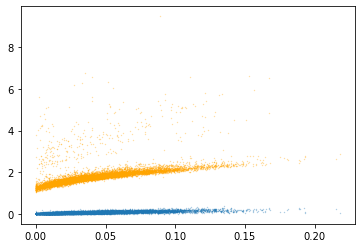

In [4]:
CN = ConvexNet(T_train, X_train, Y_train, kernel_num=100, hidden_num=100)
Y_pred = CN(T_train, X_train)
plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
plt.scatter(T_train.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

In [ ]:
TX = torch.concatenate((T_train, X_train), axis=1)
loader = data.DataLoader(dataset=data.TensorDataset(TX, Y_train), batch_size=16, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(list(CN.parameters()))

CN.train()
for epoch in range(10000):
    with tqdm(loader, unit="batch") as tepoch:
        for batch_tx, batch_y in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            batch_t = batch_tx[:, 0].reshape(-1, 1)
            batch_x = batch_tx[:, 1:]
            y_pred = CN(batch_t, batch_x)
            loss = loss_fn(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sleep(0.0001)
    period = 1
    if (epoch + 1) % period == 0:
        torch.save(CN, f'../model/top25%/CNv2_eval{epoch + 1}.pth')
        plt.figure(num=int((epoch + 1)/period))
        Y_train_pred = CN(T_train, X_train)
        plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
        plt.scatter(T_train.detach().numpy(), Y_train_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Train Epoch %d: MAE=%.3g, R^2=%.3g$' % (epoch + 1, torch.mean(torch.abs(Y_train_pred - Y_train)), r2_score(Y_train_pred, Y_train)))
        plt.show()
        plt.figure(num=int((epoch + 1)/period))
        Y_test_pred = CN(T_test, X_test)
        plt.scatter(T_test, Y_test, s=0.1, alpha=0.5)
        plt.scatter(T_test.detach().numpy(), Y_test_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Test Epoch %d: MAE=%.3g, R^2=%.3g$' % (epoch + 1, torch.mean(torch.abs(Y_test_pred - Y_test)), r2_score(Y_test_pred, Y_test)))
        plt.show()

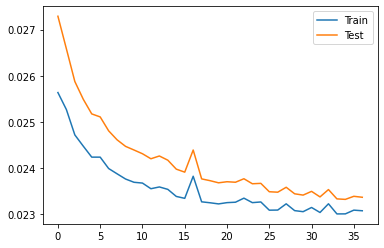

In [8]:
train_mae = []
test_mae = []
for i in range(10000):
    try:
        model = torch.load(f'../model/top25%/CNv2_eval{i + 1}.pth')
    except:
        break
    Y_train_pred = model(T_train, X_train)
    train_mae.append(torch.mean(torch.abs(Y_train_pred - Y_train)))
    Y_test_pred = model(T_test, X_test)
    test_mae.append(torch.mean(torch.abs(Y_test_pred - Y_test)))
plt.plot(list(range(1, len(train_mae) + 1)), train_mae)
plt.plot(list(range(1, len(test_mae) + 1)), test_mae)
plt.legend(['Train', 'Test'])
plt.show()

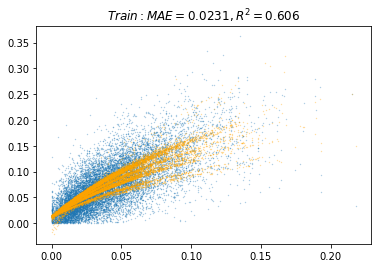

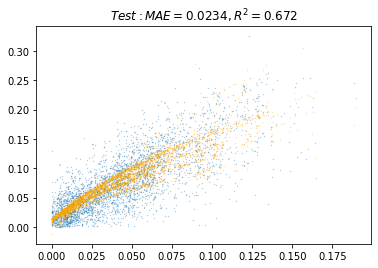

In [7]:
CN2 = torch.load('../model/top25%/CNv2_eval37.pth')

Y_train_pred = CN2(T_train, X_train)
plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
plt.scatter(T_train.detach().numpy(), Y_train_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
plt.title('$Train: MAE=%.3g, R^2=%.3g$' % (torch.mean(torch.abs(Y_train_pred - Y_train)), r2_score(Y_train_pred, Y_train)))
plt.show()

Y_test_pred = CN2(T_test, X_test)
plt.scatter(T_test, Y_test, s=0.1, alpha=0.5)
plt.scatter(T_test.detach().numpy(), Y_test_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
plt.title('$Test: MAE=%.3g, R^2=%.3g$' % (torch.mean(torch.abs(Y_test_pred - Y_test)), r2_score(Y_test_pred, Y_test)))
plt.show()


In [13]:
df1 = pd.read_csv('../data/feature_new.csv')
top = int(0.99*len(df1['city_id'].drop_duplicates()))
top_city = df1[['city_id', 'fk_gmv']].groupby('city_id').sum().reset_index().sort_values(by=['fk_gmv'], ascending=False)[:top]['city_id'].tolist()
df2 = df1[df1['city_id'].isin(top_city)]
df_train = df2[df2['dt'] < '2022-8-01']
df_test = df2[(df2['dt'] >= '2022-08-01') & (df2['dt'] < '2022-12-01')]

drop_columns = ['dt', 'group_type_exp', 'group_type_blank', 'sample_size_blank', 'sample_size_exp', 
                'snpc_fkdp_subsidy_hufan_ratio_3d', 'snpc_fkdp_subsidy_hufan_ratio_14d_term']
T_columns = ['pk_hufan_rate_exp', 'th_hufan_rate_exp', 'fk_hufan_rate_exp', 
             'fk_subsidy_exp', 'fk_subsidy_exp.1',
             'pk_hufan_rate_blank', 'th_hufan_rate_blank', 'fk_hufan_rate_blank', 
             'delta_pk_rate', 'delta_th_rate', 'delta_hufan_rate', 
             'kh_sub_rate',
             'pk_target_c_rate', 'th_target_c_rate', 'fk_target_rate'] # 有缺失值
Y_columns = ['wyc_gmv', 'kuaiche_gmv', 'tehui_gmv', 'fk_gmv',
             'pk_gmv_exp', 'th_gmv_exp', 'fk_gmv_exp', 'wc_gmv_exp', 'wyc_gmv_exp', 'wc_gmv_exp.1', 'wyc_gmv_exp.1',
             'pk_gmv_blank', 'th_gmv_blank', 'fk_gmv_blank', 
             'dgmv_ratio_pk', 'dgmv_ratio_th', 'dgmv_ratio', 
             'real_roi']
feature_columns = list(set(df2.columns) - set(drop_columns + T_columns + Y_columns))

T_train = torch.from_numpy(df_train['delta_hufan_rate'].values).reshape(-1, 1)
X_train = torch.from_numpy(df_train[feature_columns].values)
Y_train = torch.from_numpy(df_train['dgmv_ratio'].values).reshape(-1, 1)
T_test = torch.from_numpy(df_test['delta_hufan_rate'].values).reshape(-1, 1)
X_test = torch.from_numpy(df_test[feature_columns].values)
Y_test = torch.from_numpy(df_test['dgmv_ratio'].values).reshape(-1, 1)

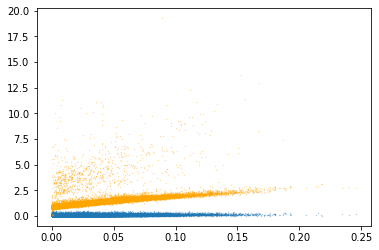

In [14]:
CN = ConvexNet(T_train, X_train, Y_train, kernel_num=100, hidden_num=100)
Y_pred = CN(T_train, X_train)
plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
plt.scatter(T_train.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)

In [ ]:
TX = torch.concatenate((T_train, X_train), axis=1)
loader = data.DataLoader(dataset=data.TensorDataset(TX, Y_train), batch_size=64, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.ASGD(list(CN.parameters()))

CN.train()
i = 0
for epoch in range(10000):
    for batch_tx, batch_y in loader:
        batch_t = batch_tx[:, 0].reshape(-1, 1)
        batch_x = batch_tx[:, 1:]
        y_pred = CN(batch_t, batch_x)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if i % 100 == 0:
            print(i)

    period = 1
    if (epoch + 1) % period == 0:
        torch.save(CN, f'../model/top99%/CNv2_eval{epoch + 1}.pth')
        plt.figure(num=int((epoch + 1)/period))
        Y_train_pred = CN(T_train, X_train)
        plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
        plt.scatter(T_train.detach().numpy(), Y_train_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Train Epoch %d: MAE=%.3g, R^2=%.3g$' % (epoch + 1, torch.mean(torch.abs(Y_train_pred - Y_train)), r2_score(Y_train_pred, Y_train)))
        plt.show()
        plt.figure(num=int((epoch + 1)/period))
        Y_test_pred = CN(T_test, X_test)
        plt.scatter(T_test, Y_test, s=0.1, alpha=0.5)
        plt.scatter(T_test.detach().numpy(), Y_test_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        plt.title('$Test Epoch %d: MAE=%.3g, R^2=%.3g$' % (epoch + 1, torch.mean(torch.abs(Y_test_pred - Y_test)), r2_score(Y_test_pred, Y_test)))
        plt.show()

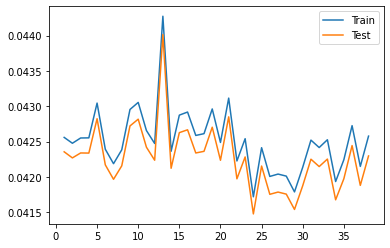

In [27]:
train_mae = []
test_mae = []
for i in range(10000):
    try:
        model = torch.load(f'../model/top99%/CNv2_eval{i + 1}.pth')
    except:
        break
    Y_train_pred = model(T_train, X_train)
    train_mae.append(torch.mean(torch.abs(Y_train_pred - Y_train)))
    Y_test_pred = model(T_test, X_test)
    test_mae.append(torch.mean(torch.abs(Y_test_pred - Y_test)))
plt.plot(list(range(1, len(train_mae) + 1)), train_mae)
plt.plot(list(range(1, len(test_mae) + 1)), test_mae)
plt.legend(['Train', 'Test'])
plt.show()

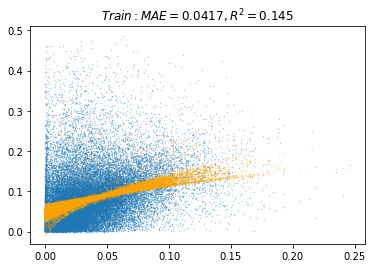

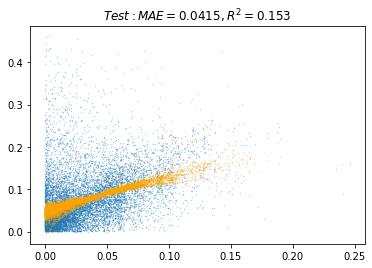

In [28]:
CN2 = torch.load('../model/top99%/CNv2_eval24.pth')

Y_train_pred = CN2(T_train, X_train)
plt.scatter(T_train, Y_train, s=0.1, alpha=0.5)
plt.scatter(T_train.detach().numpy(), Y_train_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
plt.title('$Train: MAE=%.3g, R^2=%.3g$' % (torch.mean(torch.abs(Y_train_pred - Y_train)), r2_score(Y_train_pred, Y_train)))
plt.show()

Y_test_pred = CN2(T_test, X_test)
plt.scatter(T_test, Y_test, s=0.1, alpha=0.5)
plt.scatter(T_test.detach().numpy(), Y_test_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
plt.title('$Test: MAE=%.3g, R^2=%.3g$' % (torch.mean(torch.abs(Y_test_pred - Y_test)), r2_score(Y_test_pred, Y_test)))
plt.show()
